# Object segmentations with EfficientSAM and OpenVINO

[Segment Anything Model (SAM)](https://segment-anything.com/) has emerged as a powerful tool for numerous vision applications. A key component that drives the impressive performance for zero-shot transfer and high versatility is a super large Transformer model trained on the extensive high-quality SA-1B dataset. While beneficial, the huge computation cost of SAM model has limited its applications to wider real-world applications. To address this limitation, EfficientSAMs, light-weight SAM models that exhibit decent performance with largely reduced complexity, were proposed. The idea behind EfficientSAM is based on leveraging masked image pretraining, SAMI, which learns to reconstruct features from SAM image encoder for effective visual representation learning.

![overview.png](https://yformer.github.io/efficient-sam/EfficientSAM_files/overview.png)

More details about model can be found in [paper](https://arxiv.org/pdf/2312.00863.pdf), [model web page](https://yformer.github.io/efficient-sam/) and [original repository](https://github.com/yformer/EfficientSAM)

In this tutorial we consider how to convert and run EfficientSAM using OpenVINO

## Prerequisites

In [1]:
%pip uninstall -y -q openvino openvino-dev openvino-nightly
%pip install -q openvino-nightly opencv-python matplotlib gradio torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu

In [2]:
from pathlib import Path

repo_dir = Path("EfficientSAM")

if not repo_dir.exists():
    !git clone https://github.com/yformer/EfficientSAM.git
%cd $repo_dir

/home/ea/work/openvino_notebooks/notebooks/274-efficient-sam/EfficientSAM


## Load PyTorch model

There are several models available in the repository:

* **efficient-sam-vitt** - EfficientSAM with Vision Transformer Tiny (VIT-T) as image encoder. The smallest and fastest model from EfficientSAM family.
* **efficient-sam-vits** - EfficientSAM with Vision Transformer Small (VIT-S) as image encoder. Heavier than efficient-sam-vitt, but more accurate model.

EfficientSAM provides a unified interface for interaction with models. It means that all provided steps in the notebook for conversion and running the model will be the same for all models. Below, you can select one of them as example.

In [3]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
import zipfile

MODELS_LIST = {"efficient-sam-vitt": build_efficient_sam_vitt, "efficient-sam-vits": build_efficient_sam_vits}

# Since EfficientSAM-S checkpoint file is >100MB, we store the zip file.
with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
    zip_ref.extractall("weights")

Select one from supported models:

In [4]:
import ipywidgets as widgets

model_ids = list(MODELS_LIST)

model_id = widgets.Dropdown(
    options=model_ids,
    value=model_ids[0],
    description="Model:",
    disabled=False,
)

model_id

Dropdown(description='Model:', options=('efficient-sam-vitt', 'efficient-sam-vits'), value='efficient-sam-vitt…

build PyTorch model

In [5]:
pt_model = MODELS_LIST[model_id.value]()

pt_model.eval();

## Run PyTorch model inference
Now, when we selected and loaded PyTorch model, we can check its result

### Prepare input data

First of all, we should prepare input data for model. Model has 3 inputs:
* image tensor - tensor with normalized input image.
* input points - tensor with user provided points. It maybe just some specific points on the image (e.g. provided by user clicks on the screen) or bounding box coordinates in format left-top angle point and right-bottom angle pint.
* input labels - tensor with definition of point type for each provided point, 1 - for regular point, 2 - left-top point of bounding box, 3 - right-bottom point of bounding box.

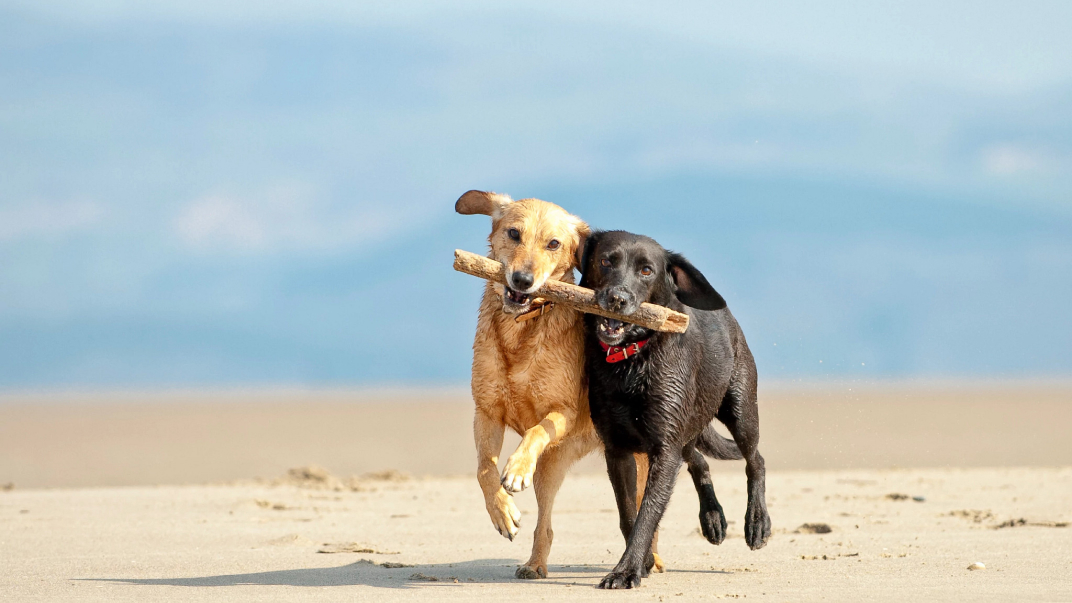

In [6]:
from PIL import Image

image_path = "figs/examples/dogs.jpg"

image = Image.open(image_path)
image

### Define helpers for input and output processing

The code below defines helpers for preparing model input and postprocess inference results. The input format is accepted by the model described above. The model predicts mask logits for each pixel on the image and intersection over union score for each area, how close it is to provided points. We also provided some helper function for results visualization.

In [7]:
import torch
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np


def prepare_input(input_image, points, labels, torch_tensor=True):
    img_tensor = np.ascontiguousarray(input_image)[None, ...].astype(np.float32) / 255
    img_tensor = np.transpose(img_tensor, (0, 3, 1, 2))
    pts_sampled = np.reshape(np.ascontiguousarray(points), [1, 1, -1, 2])
    pts_labels = np.reshape(np.ascontiguousarray(labels), [1, 1, -1])
    if torch_tensor:
        img_tensor = torch.from_numpy(img_tensor)
        pts_sampled = torch.from_numpy(pts_sampled)
        pts_labels = torch.from_numpy(pts_labels)
    return img_tensor, pts_sampled, pts_labels


def postprocess_results(predicted_iou, predicted_logits):
    sorted_ids = np.argsort(-predicted_iou, axis=-1)
    predicted_iou = np.take_along_axis(predicted_iou, sorted_ids, axis=2)
    predicted_logits = np.take_along_axis(
        predicted_logits, sorted_ids[..., None, None], axis=2
    )

    return predicted_logits[0, 0, 0, :, :] >= 0

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="yellow", facecolor=(0, 0, 0, 0), lw=5)
    )


def show_anns(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:, :, 3] = 0
    # for ann in mask:
    #     m = ann
    color_mask = np.concatenate([np.random.random(3), [0.5]])
    img[mask] = color_mask
    ax.imshow(img)

The complete model inference example demonstrated below

In [8]:
input_points = [[580, 350], [650, 350]]
input_labels = [1, 1]

example_input = prepare_input(image, input_points, input_labels)

predicted_logits, predicted_iou = pt_model(*example_input)

predicted_mask = postprocess_results(predicted_iou.detach().numpy(), predicted_logits.detach().numpy())

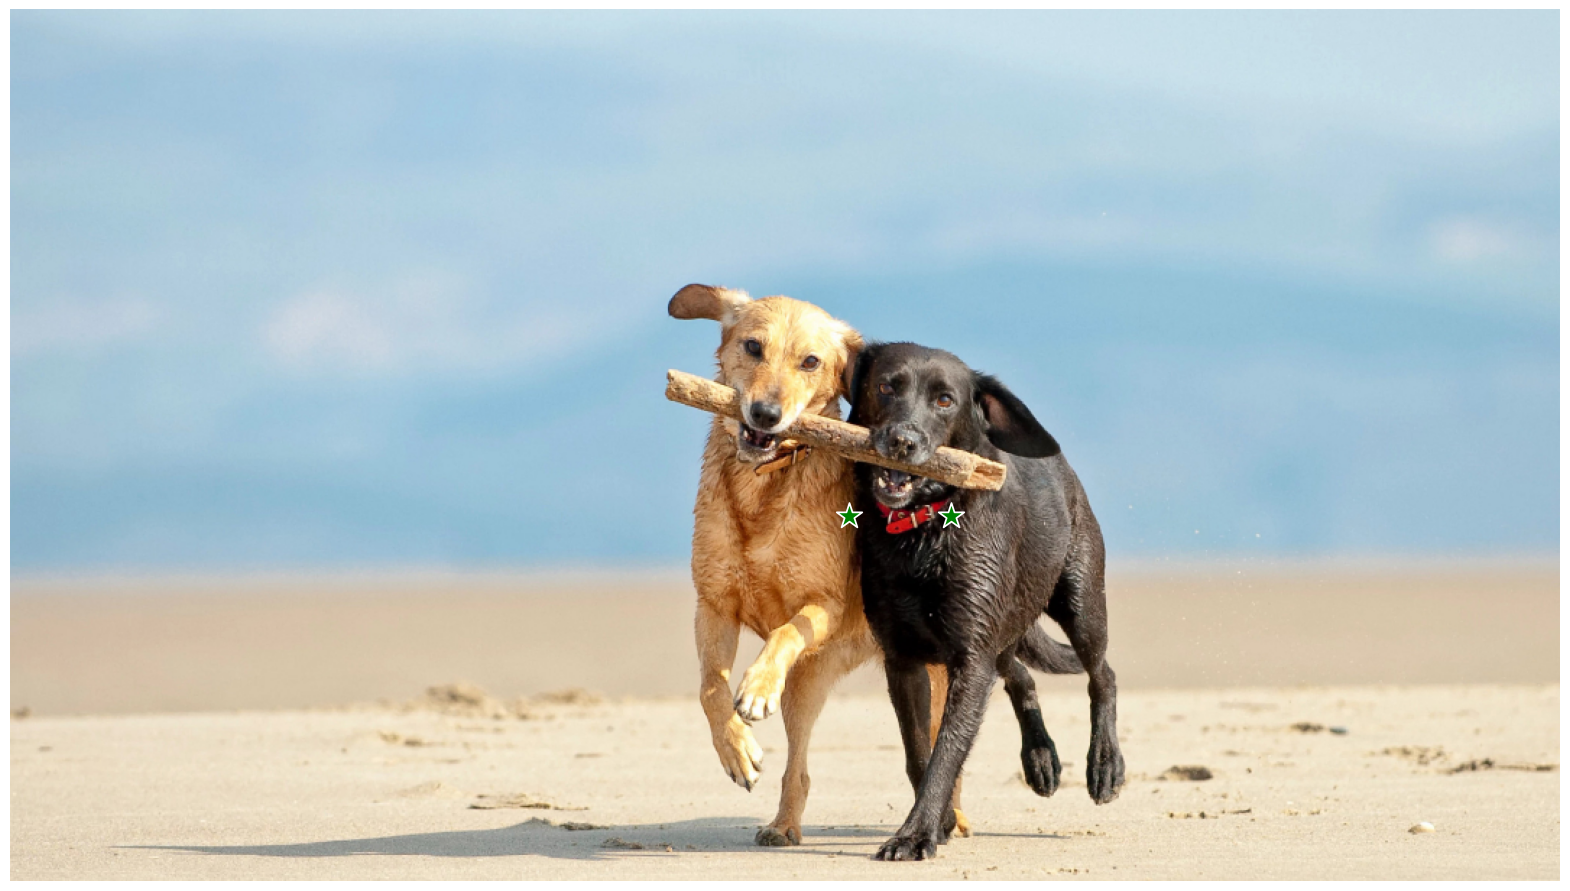

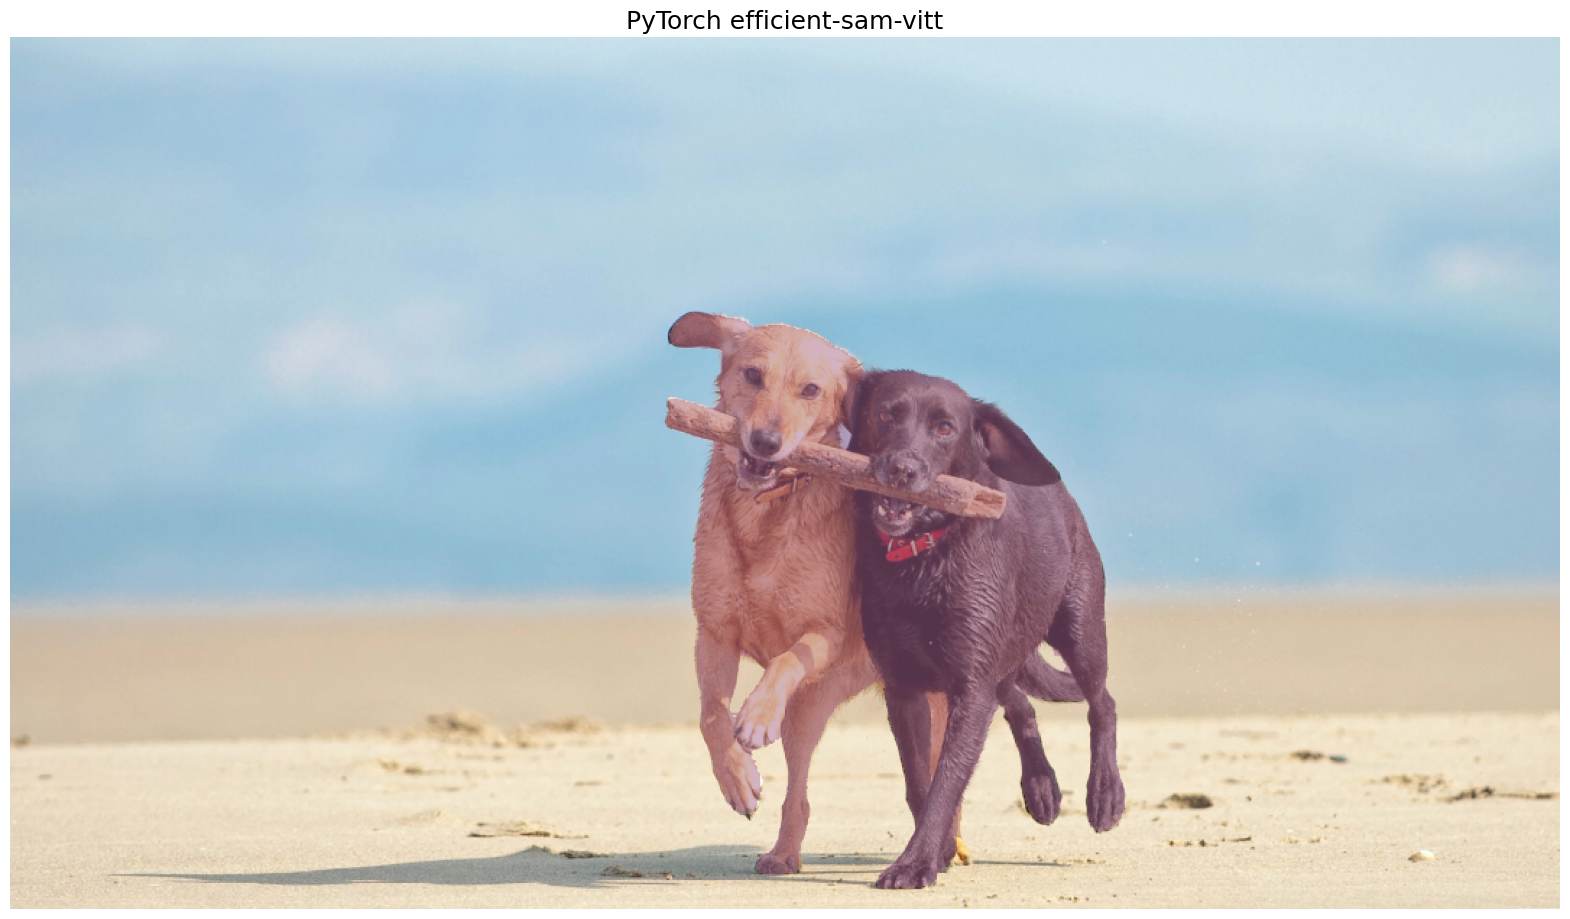

In [9]:
image = Image.open(image_path)

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(image)
show_points(np.array(input_points), np.array(input_labels), plt.gca())
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(image)
show_anns(predicted_mask, plt.gca())
plt.title(f"PyTorch {model_id.value}", fontsize=18)
plt.show()

## Convert model to OpenVINO IR format

OpenVINO supports PyTorch models via conversion in Intermediate Representation (IR) format using OpenVINO [Model Conversion API](https://docs.openvino.ai/2023.2/openvino_docs_model_processing_introduction.html). `openvino.convert_model` function accepts instance of PyTorch model and example input (that helps in correct model operation tracing and shape inference) and returns `openvino.Model` object that represents model in OpenVINO framework. This `openvino.Model` is ready for loading on the device using `ov.Core.compile_model` or can be saved on disk using `openvino.save_model`.

In [10]:
import openvino as ov

core = ov.Core()

ov_model_path = Path(f'{model_id.value}.xml')

if not ov_model_path.exists():
    ov_model = ov.convert_model(pt_model, example_input=example_input)
    ov.save_model(ov_model, ov_model_path)
else:
    ov_model = core.read_model(ov_model_path)

## Run OpenVINO model inference

### Select inference device from dropdown list

In [11]:
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GNA', 'AUTO'), value='AUTO')

### Compile OpenVINO model

In [12]:
compiled_model = core.compile_model(ov_model, device.value)

### Inference and visualize result

Now, we can take a look on OpenVINO model prediction

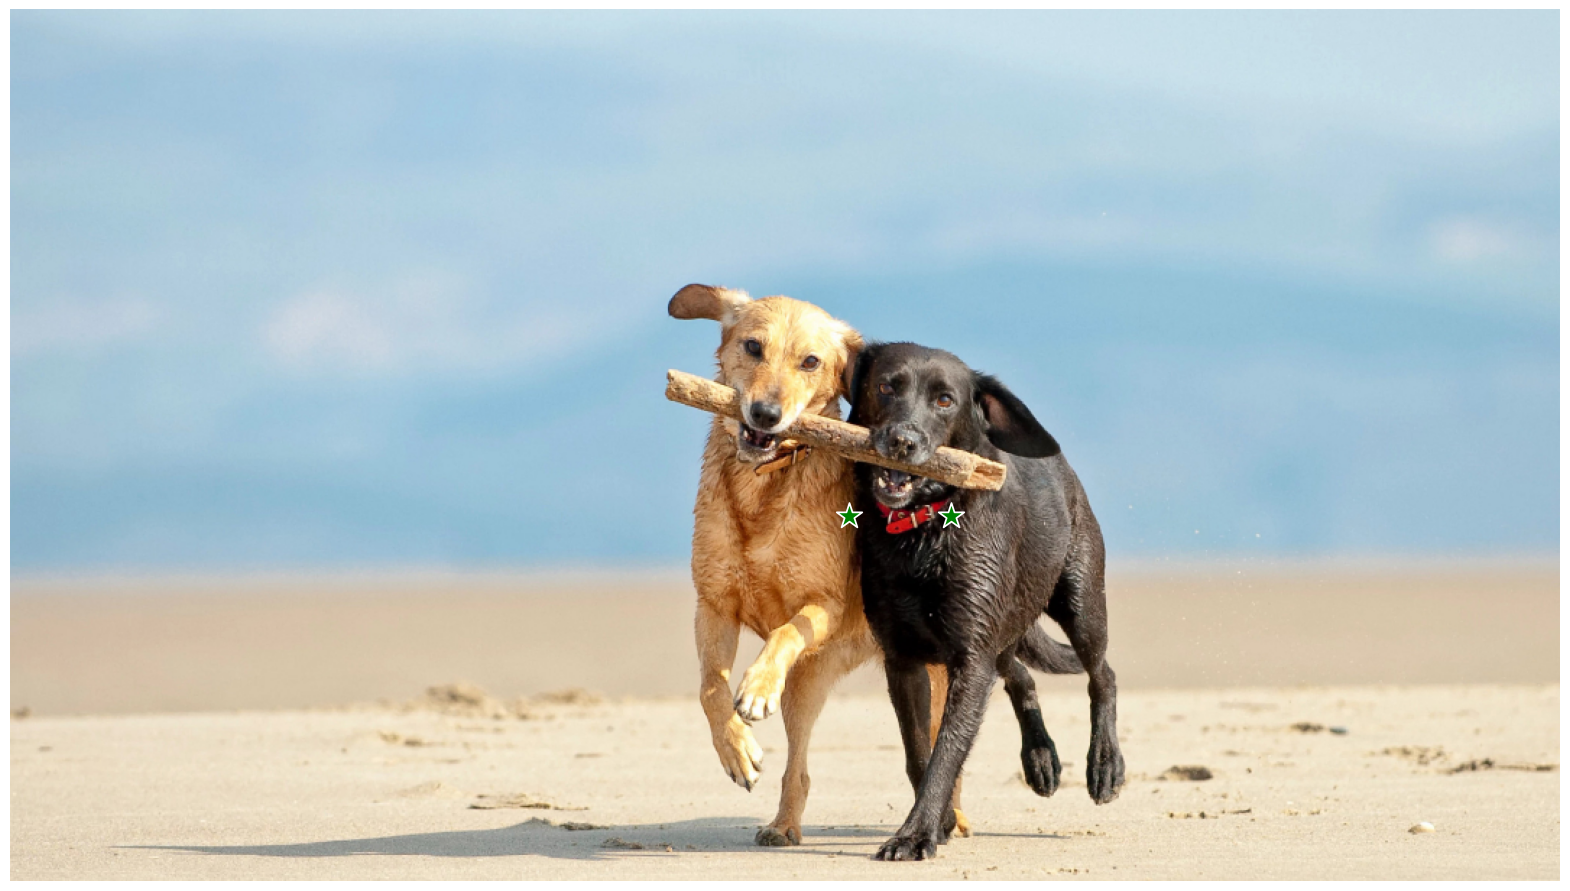

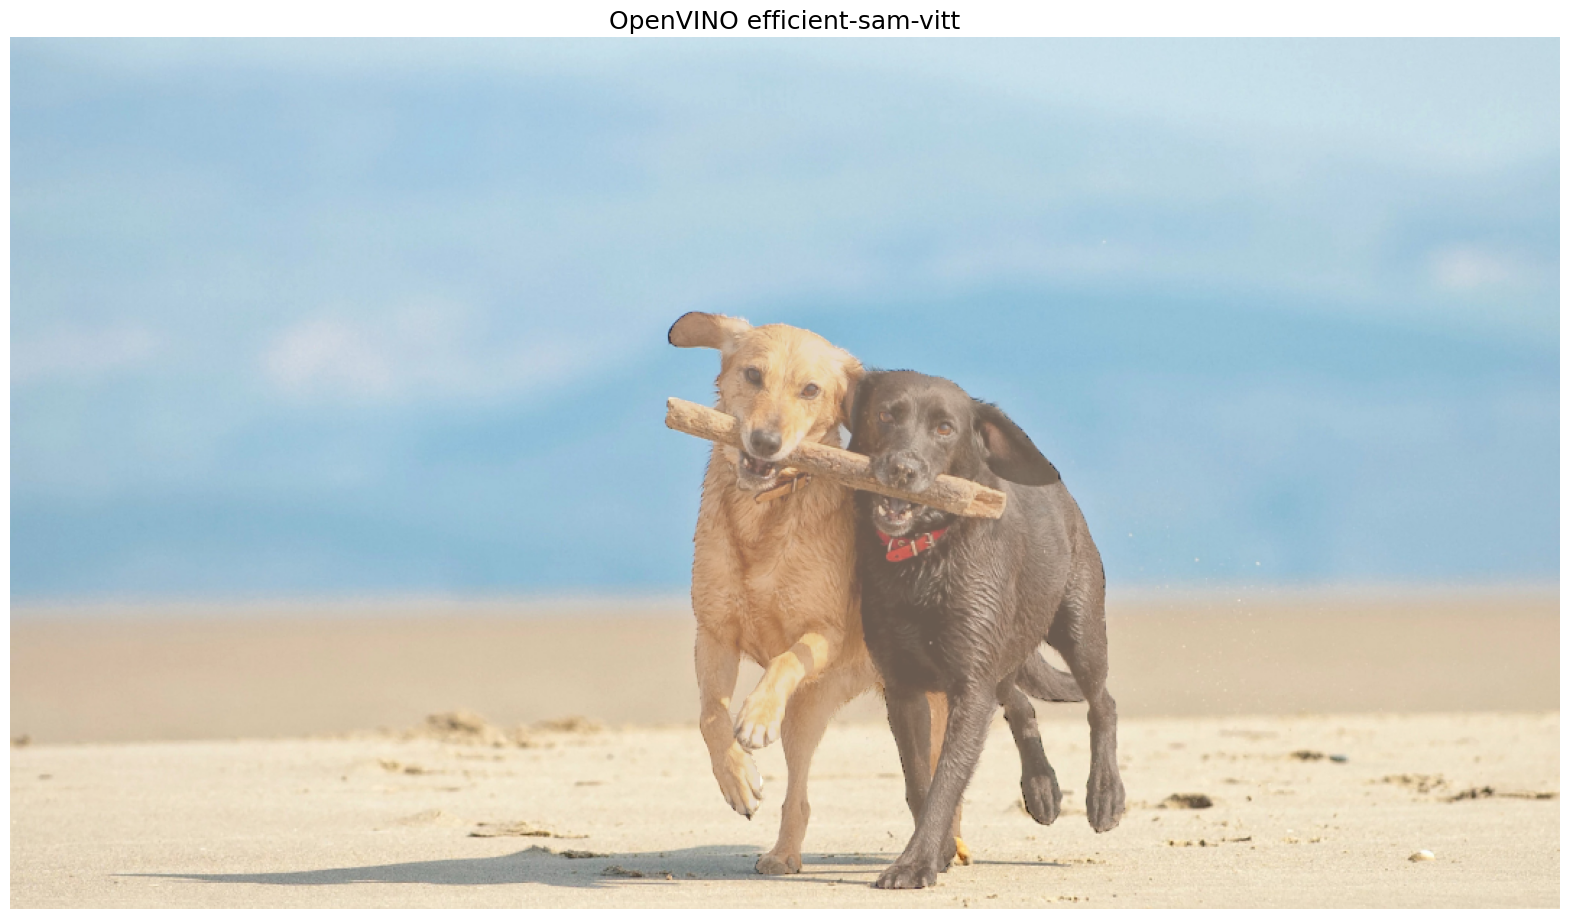

In [13]:

example_input = prepare_input(image, input_points, input_labels, torch_tensor=False)
result = compiled_model(example_input)

predicted_logits, predicted_iou = result[0], result[1]

predicted_mask = postprocess_results(predicted_iou, predicted_logits)

plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(image)
show_points(np.array(input_points), np.array(input_labels), plt.gca())
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.imshow(image)
show_anns(predicted_mask, plt.gca())
plt.title(f"OpenVINO {model_id.value}", fontsize=18)
plt.show()

## Interactive segmentation demo

In [ ]:
import copy
import urllib
import gradio as gr
import numpy as np
import torch
from PIL import ImageDraw, Image
import cv2
import matplotlib.pyplot as plt

example_images = [
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/b8083dd5-1ce7-43bf-8b09-a2ebc280c86e",
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/9a90595d-70e7-469b-bdaf-469ef4f56fa2",
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/b626c123-9fa2-4aa6-9929-30565991bf0c",
    "https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/803dc659-3584-45c3-aab2-d7009ebcd579",
]

examples_dir = Path("examples")
examples_dir.mkdir(exist_ok=True)

for img_id, image_url in enumerate(example_images):
    urllib.request.urlretrieve(image_url, examples_dir / f"example_{img_id}.jpg")

def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

def format_results(masks, scores, logits, filter=0):
    annotations = []
    n = len(scores)
    for i in range(n):
        annotation = {}

        mask = masks[i]
        tmp = np.where(mask != 0)
        if np.sum(mask) < filter:
            continue
        annotation["id"] = i
        annotation["segmentation"] = mask
        annotation["bbox"] = [np.min(tmp[0]), np.min(tmp[1]), np.max(tmp[1]), np.max(tmp[0])]
        annotation["score"] = scores[i]
        annotation["area"] = annotation["segmentation"].sum()
        annotations.append(annotation)
    return annotations

def point_prompt(masks, points, point_label, target_height, target_width):  # numpy
    h = masks[0]["segmentation"].shape[0]
    w = masks[0]["segmentation"].shape[1]
    if h != target_height or w != target_width:
        points = [
            [int(point[0] * w / target_width), int(point[1] * h / target_height)]
            for point in points
        ]
    onemask = np.zeros((h, w))
    for i, annotation in enumerate(masks):
        if isinstance(annotation, dict):
            mask = annotation["segmentation"]
        else:
            mask = annotation
        for i, point in enumerate(points):
            if point[1] < mask.shape[0] and point[0] < mask.shape[1]:
                if mask[point[1], point[0]] == 1 and point_label[i] == 1:
                    onemask += mask
                if mask[point[1], point[0]] == 1 and point_label[i] == 0:
                    onemask -= mask
    onemask = onemask >= 1
    return onemask, 0

def show_mask(
    annotation,
    ax,
    random_color=False,
    bbox=None,
    retinamask=True,
    target_height=960,
    target_width=960,
):
    mask_sum = annotation.shape[0]
    height = annotation.shape[1]
    weight = annotation.shape[2]
    # annotation is sorted by area
    areas = np.sum(annotation, axis=(1, 2))
    sorted_indices = np.argsort(areas)[::1]
    annotation = annotation[sorted_indices]

    index = (annotation != 0).argmax(axis=0)
    if random_color:
        color = np.random.random((mask_sum, 1, 1, 3))
    else:
        color = np.ones((mask_sum, 1, 1, 3)) * np.array([30 / 255, 144 / 255, 255 / 255])
    transparency = np.ones((mask_sum, 1, 1, 1)) * 0.6
    visual = np.concatenate([color, transparency], axis=-1)
    mask_image = np.expand_dims(annotation, -1) * visual

    mask = np.zeros((height, weight, 4))

    h_indices, w_indices = np.meshgrid(
        np.arange(height), np.arange(weight), indexing="ij"
    )
    indices = (index[h_indices, w_indices], h_indices, w_indices, slice(None))

    mask[h_indices, w_indices, :] = mask_image[indices]
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor="b", linewidth=1))

    if not retinamask:
        mask = cv2.resize(mask, (target_width, target_height), interpolation=cv2.INTER_NEAREST)

    return mask

def process(
    annotations,
    image,
    scale,
    better_quality=False,
    mask_random_color=True,
    bbox=None,
    points=None,
    use_retina=True,
    withContours=True,
):
    if isinstance(annotations[0], dict):
        annotations = [annotation["segmentation"] for annotation in annotations]

    original_h = image.height
    original_w = image.width
    if better_quality:
        if isinstance(annotations[0], torch.Tensor):
            annotations = np.array(annotations)
        for i, mask in enumerate(annotations):
            mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
            annotations[i] = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((8, 8), np.uint8))
    annotations = np.array(annotations)
    inner_mask = show_mask(
        annotations,
        plt.gca(),
        random_color=mask_random_color,
        bbox=bbox,
        retinamask=use_retina,
        target_height=original_h,
        target_width=original_w,
    )

    if isinstance(annotations, torch.Tensor):
        annotations = annotations.cpu().numpy()

    if withContours:
        contour_all = []
        temp = np.zeros((original_h, original_w, 1))
        for i, mask in enumerate(annotations):
            if type(mask) == dict:
                mask = mask["segmentation"]
            annotation = mask.astype(np.uint8)
            if use_retina == False:
                annotation = cv2.resize(
                    annotation,
                    (original_w, original_h),
                    interpolation=cv2.INTER_NEAREST,
                )
            contours, _ = cv2.findContours(
                annotation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            for contour in contours:
                contour_all.append(contour)
        cv2.drawContours(temp, contour_all, -1, (255, 255, 255), 2 // scale)
        color = np.array([0 / 255, 0 / 255, 255 / 255, 0.9])
        contour_mask = temp / 255 * color.reshape(1, 1, -1)

    image = image.convert("RGBA")
    overlay_inner = Image.fromarray((inner_mask * 255).astype(np.uint8), "RGBA")
    image.paste(overlay_inner, (0, 0), overlay_inner)

    if withContours:
        overlay_contour = Image.fromarray((contour_mask * 255).astype(np.uint8), "RGBA")
        image.paste(overlay_contour, (0, 0), overlay_contour)

    return image



# Description
title = "<center><strong><font size='8'>Efficient Segment Anything with OpenVINO and EfficientSAM <font></strong></center>"


description_p = """# Interactive Instance Segmentation
                - Point-prompt instruction
                <ol>
                <li> Click on the left image (point input), visualizing the point on the right image </li>
                <li> Click the button of Segment with Point Prompt </li>
                </ol>
                - Box-prompt instruction
                <ol>
                <li> Click on the left image (one point input), visualizing the point on the right image </li>
                <li> Click on the left image (another point input), visualizing the point and the box on the right image</li>
                <li> Click the button of Segment with Box Prompt </li>
                </ol>
              """

# examples
examples = [ [img] for img in examples_dir.glob("*.jpg")]

default_example = examples[0]

css = "h1 { text-align: center } .about { text-align: justify; padding-left: 10%; padding-right: 10%; }"


def segment_with_boxs(
    image,
    seg_image,
    global_points,
    global_point_label,
    input_size=1024,
    better_quality=False,
    withContours=True,
    use_retina=True,
    mask_random_color=True,
):
    if len(global_points) < 2:
        return seg_image, global_points, global_point_label

    input_size = int(input_size)
    w, h = image.size
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    image = image.resize((new_w, new_h))

    scaled_points = np.array(
        [[int(x * scale) for x in point] for point in global_points]
    )
    scaled_points = scaled_points[:2]
    scaled_point_label = np.array(global_point_label)[:2]

    if scaled_points.size == 0 and scaled_point_label.size == 0:
        return image, global_points, global_point_label

    nd_image = np.array(image)
    img_tensor = nd_image.astype(np.float32) / 255
    img_tensor = np.transpose(img_tensor, (2, 0, 1))

    pts_sampled = np.reshape(scaled_points, [1, 1, -1, 2])
    pts_sampled = pts_sampled[:, :, :2, :]
    pts_labels = np.reshape(np.array([2, 3]), [1, 1, 2])

    results = compiled_model(
        [img_tensor[None, ...],
        pts_sampled,
        pts_labels]
    )
    predicted_logits = results[0]
    predicted_iou = results[1]
    all_masks = sigmoid(predicted_logits[0, 0, :, :, :]) >= 0.5
    predicted_iou = predicted_iou[0, 0, ...]


    max_predicted_iou = -1
    selected_mask_using_predicted_iou = None
    selected_predicted_iou = None

    for m in range(all_masks.shape[0]):
        curr_predicted_iou = predicted_iou[m]
        if (
            curr_predicted_iou > max_predicted_iou
            or selected_mask_using_predicted_iou is None
        ):
            max_predicted_iou = curr_predicted_iou
            selected_mask_using_predicted_iou = all_masks[m:m+1]
            selected_predicted_iou = predicted_iou[m:m+1]

    results = format_results(selected_mask_using_predicted_iou, selected_predicted_iou, predicted_logits, 0)

    annotations = results[0]["segmentation"]
    annotations = np.array([annotations])
    fig = process(
        annotations=annotations,
        image=image,
        scale=(1024 // input_size),
        better_quality=better_quality,
        mask_random_color=mask_random_color,
        use_retina=use_retina,
        bbox = scaled_points.reshape([4]),
        withContours=withContours,
    )

    global_points = []
    global_point_label = []
    # return fig, None
    return fig, global_points, global_point_label


def segment_with_points(
    image,
    global_points,
    global_point_label,
    input_size=1024,
    better_quality=False,
    withContours=True,
    use_retina=True,
    mask_random_color=True,
):
    input_size = int(input_size)
    w, h = image.size
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    image = image.resize((new_w, new_h))

    if global_points is None:
        return image, global_points, global_point_label
    if len(global_points) < 1:
        return image, global_points, global_point_label
    scaled_points = np.array(
        [[int(x * scale) for x in point] for point in global_points]
    )
    scaled_point_label = np.array(global_point_label)

    if scaled_points.size == 0 and scaled_point_label.size == 0:
        return image, global_points, global_point_label

    nd_image = np.array(image)
    img_tensor = (nd_image).astype(np.float32) / 255
    img_tensor = np.transpose(img_tensor, (2, 0, 1))

    pts_sampled = np.reshape(scaled_points, [1, 1, -1, 2])
    pts_labels = np.reshape(np.array(global_point_label), [1, 1, -1])

    results = compiled_model(
        [img_tensor[None, ...],
        pts_sampled,
        pts_labels]
    )
    predicted_logits = results[0]
    predicted_iou = results[1]
    all_masks = sigmoid(predicted_logits[0, 0, :, :, :]) >= 0.5
    predicted_iou = predicted_iou[0, 0, ...]

    results = format_results(all_masks, predicted_iou, predicted_logits, 0)

    annotations, _ = point_prompt(
        results, scaled_points, scaled_point_label, new_h, new_w
    )
    annotations = np.array([annotations])

    fig = process(
        annotations=annotations,
        image=image,
        scale=(1024 // input_size),
        better_quality=better_quality,
        mask_random_color=mask_random_color,
        points = scaled_points,
        bbox=None,
        use_retina=use_retina,
        withContours=withContours,
    )

    global_points = []
    global_point_label = []
    # return fig, None
    return fig, global_points, global_point_label


def get_points_with_draw(image, cond_image, global_points, global_point_label, evt: gr.SelectData):
    if len(global_points) == 0:
        image = copy.deepcopy(cond_image)
    x, y = evt.index[0], evt.index[1]
    label = "Add Mask"
    point_radius, point_color = 15, (255, 255, 0) if label == "Add Mask" else (
        255,
        0,
        255,
    )
    global_points.append([x, y])
    global_point_label.append(1 if label == "Add Mask" else 0)

    if image is not None:
        draw = ImageDraw.Draw(image)

        draw.ellipse(
            [(x - point_radius, y - point_radius), (x + point_radius, y + point_radius)],
            fill=point_color,
        )

    return image, global_points, global_point_label

def get_points_with_draw_(image, cond_image, global_points, global_point_label, evt: gr.SelectData):

    if len(global_points) == 0:
        image = copy.deepcopy(cond_image)
    if len(global_points) > 2:
        return image, global_points, global_point_label
    x, y = evt.index[0], evt.index[1]
    label = "Add Mask"
    point_radius, point_color = 15, (255, 255, 0) if label == "Add Mask" else (
        255,
        0,
        255,
    )
    global_points.append([x, y])
    global_point_label.append(1 if label == "Add Mask" else 0)

    if image is not None:
        draw = ImageDraw.Draw(image)

        draw.ellipse(
            [(x - point_radius, y - point_radius), (x + point_radius, y + point_radius)],
            fill=point_color,
        )

    if len(global_points) == 2:
        x1, y1 = global_points[0]
        x2, y2 = global_points[1]
        if x1 < x2 and y1 < y2:
            draw.rectangle([x1, y1, x2, y2], outline="red", width=5)
        elif x1 < x2 and y1 >= y2:
            draw.rectangle([x1, y2, x2, y1], outline="red", width=5)
            global_points[0][0] = x1
            global_points[0][1] = y2
            global_points[1][0] = x2
            global_points[1][1] = y1
        elif x1 >= x2 and y1 < y2:
            draw.rectangle([x2, y1, x1, y2], outline="red", width=5)
            global_points[0][0] = x2
            global_points[0][1] = y1
            global_points[1][0] = x1
            global_points[1][1] = y2
        elif x1 >= x2 and y1 >= y2:
            draw.rectangle([x2, y2, x1, y1], outline="red", width=5)
            global_points[0][0] = x2
            global_points[0][1] = y2
            global_points[1][0] = x1
            global_points[1][1] = y1

    return image, global_points, global_point_label


cond_img_p = gr.Image(label="Input with Point", value=default_example[0], type="pil")
cond_img_b = gr.Image(label="Input with Box", value=default_example[0], type="pil")

segm_img_p = gr.Image(
    label="Segmented Image with Point-Prompt", interactive=False, type="pil"
)
segm_img_b = gr.Image(
    label="Segmented Image with Box-Prompt", interactive=False, type="pil"
)

input_size_slider = gr.components.Slider(
    minimum=512,
    maximum=1024,
    value=1024,
    step=64,
    label="Input_size",
    info="Our model was trained on a size of 1024",
)

with gr.Blocks(css=css, title="Efficient SAM") as demo:
    global_points = gr.State([])
    global_point_label = gr.State([])
    with gr.Row():
        with gr.Column(scale=1):
            # Title
            gr.Markdown(title)

    with gr.Tab("Point mode"):
        # Images
        with gr.Row(variant="panel"):
            with gr.Column(scale=1):
                cond_img_p.render()

            with gr.Column(scale=1):
                segm_img_p.render()

        # Submit & Clear
        # ###
        with gr.Row():
            with gr.Column():

                with gr.Column():
                    segment_btn_p = gr.Button(
                        "Segment with Point Prompt", variant="primary"
                    )
                    clear_btn_p = gr.Button("Clear", variant="secondary")

                gr.Markdown("Try some of the examples below ⬇️")
                gr.Examples(
                    examples=examples,
                    inputs=[cond_img_p],
                    examples_per_page=4,
                )

            with gr.Column():
                # Description
                gr.Markdown(description_p)

    with gr.Tab("Box mode"):
        # Images
        with gr.Row(variant="panel"):
            with gr.Column(scale=1):
                cond_img_b.render()

            with gr.Column(scale=1):
                segm_img_b.render()

        # Submit & Clear
        with gr.Row():
            with gr.Column():

                with gr.Column():
                    segment_btn_b = gr.Button(
                        "Segment with Box Prompt", variant="primary"
                    )
                    clear_btn_b = gr.Button("Clear", variant="secondary")

                gr.Markdown("Try some of the examples below ⬇️")
                gr.Examples(
                    examples=examples,
                    inputs=[cond_img_b],

                    examples_per_page=4,
                )

            with gr.Column():
                # Description
                gr.Markdown(description_p)

    cond_img_p.select(get_points_with_draw, inputs=[segm_img_p, cond_img_p, global_points, global_point_label], outputs=[segm_img_p, global_points, global_point_label])

    cond_img_b.select(get_points_with_draw_, [segm_img_b, cond_img_b, global_points, global_point_label], [segm_img_b, global_points, global_point_label])

    segment_btn_p.click(
        segment_with_points, inputs=[cond_img_p, global_points, global_point_label], outputs=[segm_img_p, global_points, global_point_label]
    )

    segment_btn_b.click(
        segment_with_boxs, inputs=[cond_img_b, segm_img_b, global_points, global_point_label], outputs=[segm_img_b,global_points, global_point_label]
    )

    def clear():
        return None, None, [], []

    clear_btn_p.click(clear, outputs=[cond_img_p, segm_img_p, global_points, global_point_label])
    clear_btn_b.click(clear, outputs=[cond_img_b, segm_img_b, global_points, global_point_label])

demo.queue()
demo.launch(share=True)